LIBRARiES

In [16]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


PATH TO DATASET

In [2]:
DATA_DIR = 'C:/MiniProject/genres'

FEATURE EXTRACTION

In [3]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        return np.hstack([np.mean(mfccs, axis=1), np.mean(chroma, axis=1),
                         np.mean(mel, axis=1), np.mean(contrast, axis=1),
                         np.mean(tonnetz, axis=1)])
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

In [4]:
def load_data(data_dir):
    features = []
    labels = []
    genres = os.listdir(data_dir)
    for genre in genres:
        genre_dir = os.path.join(data_dir, genre)
        if os.path.isdir(genre_dir):
            for file_name in os.listdir(genre_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(genre_dir, file_name)
                    feature = extract_features(file_path)
                    if feature is not None:
                        features.append(feature)
                        labels.append(genre)
    return np.array(features), np.array(labels)


In [5]:
X, y = load_data(DATA_DIR)
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (999, 166)
Labels shape: (999,)


In [14]:
features_df = pd.DataFrame(X, columns=[f'MFCC_{i+1}' for i in range(X.shape[1])])
features_df['Genre'] = y

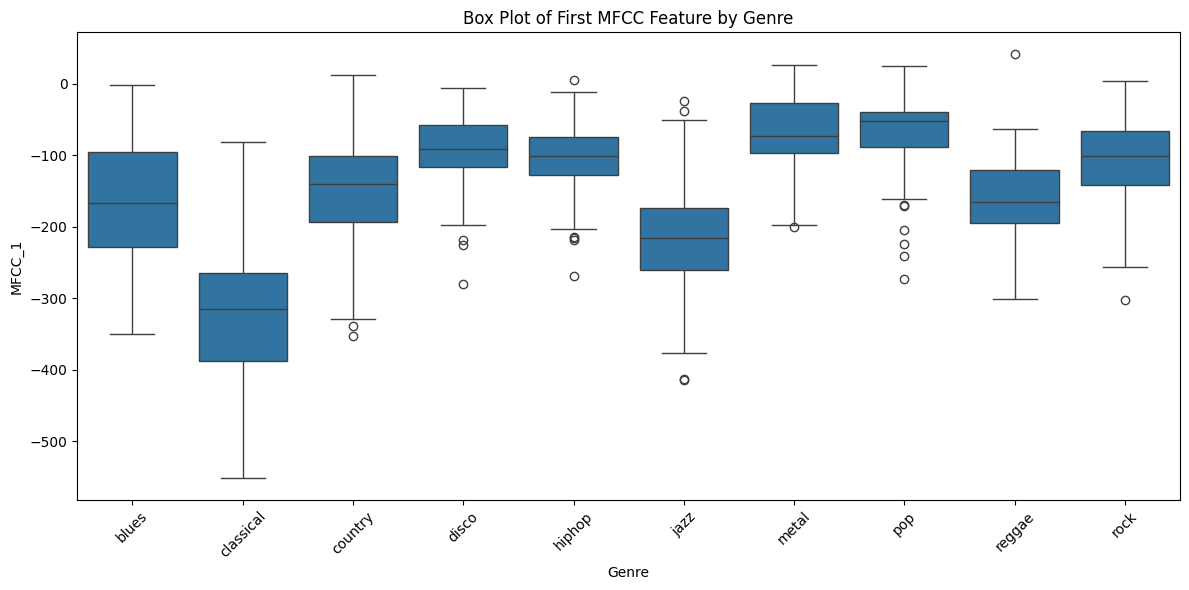

In [17]:
# Generate the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='MFCC_1', data=features_df)
plt.title('Box Plot of First MFCC Feature by Genre')
plt.xlabel('Genre')
plt.ylabel('MFCC_1')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

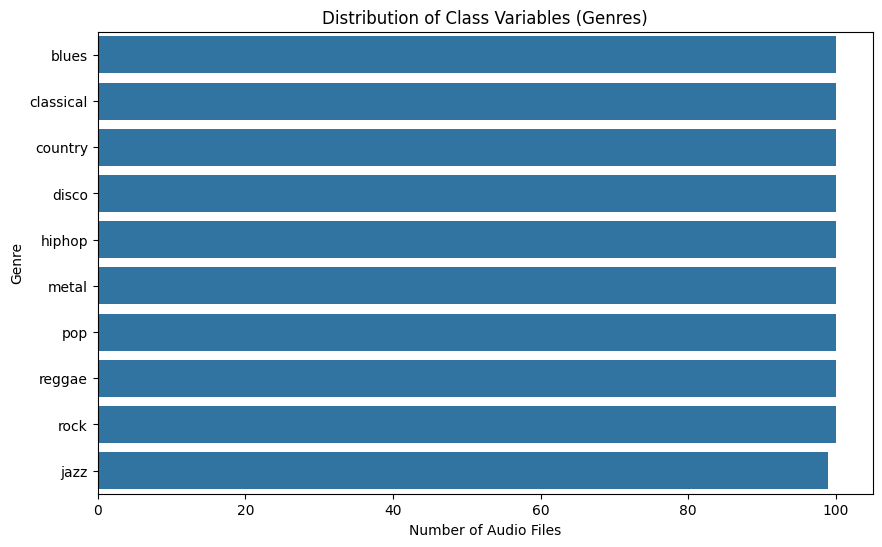

In [19]:
def load_data(data_dir):
    """Load genre labels from the dataset directory."""
    labels = []
    genres = os.listdir(data_dir)
    for genre in genres:
        genre_dir = os.path.join(data_dir, genre)
        if os.path.isdir(genre_dir):
            labels.extend([genre] * len(os.listdir(genre_dir)))  # Append genre for each audio file
    return labels

# Load the genre labels
labels = load_data(DATA_DIR)

# Convert to a DataFrame for easier plotting
labels_df = pd.DataFrame(labels, columns=['Genre'])

# Plotting the distribution of class variables
plt.figure(figsize=(10, 6))
sns.countplot(y='Genre', data=labels_df, order=labels_df['Genre'].value_counts().index)
plt.title('Distribution of Class Variables (Genres)')
plt.xlabel('Number of Audio Files')
plt.ylabel('Genre')
plt.show()


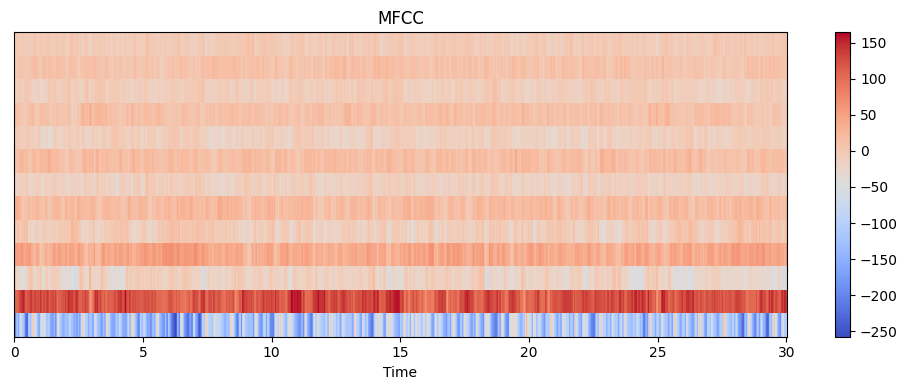

In [20]:

file_path = 'C:/MiniProject/genres/blues/blues.00000.wav'
y, sr = librosa.load(file_path, sr=None)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


In [6]:
if X.shape[0] == 0:
    raise ValueError("No audio files found. Please check your dataset directory.")

In [7]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


In [9]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=1000))
])
model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(n_estimators=1000))])

In [10]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.73


In [11]:
from joblib import dump, load

dump(model, 'music_gener_model.joblib')

['music_gener_model.joblib']

In [12]:
def predict_genre(file_path, model, label_encoder):
    # Extract features from the input file
    features = extract_features(file_path)
    
    # Check if feature extraction was successful
    if features is None:
        raise ValueError("Feature extraction failed. Check the input audio file.")
    
    # Reshape the feature array to match the input shape expected by the model
    features = features.reshape(1, -1)
    
    # Predict the genre
    predicted_label = model.predict(features)
    
    # Convert the numerical label back to the genre name
    predicted_genre = label_encoder.inverse_transform(predicted_label)
    
    return predicted_genre[0]


In [13]:
# Path to the user's audio file
user_file_path = 'C:/MiniProject/genres/jazz/jazz.00006.wav'

# Predict the genre of the user input
predicted_genre = predict_genre(user_file_path, model, label_encoder)
print(f'The predicted genre for the given audio file is: {predicted_genre}')


The predicted genre for the given audio file is: jazz
